# Projektarbeit Daten Modellierung DIS08
- Kaggle Dataset: UCL | Matches & Players Data 2021-22
- Webscraping: Transfermarkt | Marktwerte der ersten 4 Teams in der Ucl session
    -  Manchester City
    - Real Madrid
    - Liverpool FC
    - Villarreal CF
    
- Fragestellung:

    „Gibt es einen Zusammenhang zwischen dem Marktwert eines Spielers und seiner Gesamtleistung (z. B. Tackles, Passgenauigkeit, Ballgewinne) in der Champions League Sesion 2021-22?“

## 1. Kaggle Daten herunterladen

In [2]:
# Kaggle-API installieren
!pip install kaggle

In [4]:
# Kaggle API-Token einrichten
# gehe zu den Kaggle Einstelungen, dann zu "API", dann create new token, füge die kaggle.json datei in den selben ordner wie diese datei, ändere den pfad unten zu deiner kaggle.json Datei
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/Users/gengebhardt/Documents/Dev/Python/Datenmodellierung/Projektarbeit_DIS08/kaggle.json' 

In [5]:
# Datensatz von Kaggle herunterladen
!kaggle datasets download -d azminetoushikwasi/ucl-202122-uefa-champions-league

Dataset URL: https://www.kaggle.com/datasets/azminetoushikwasi/ucl-202122-uefa-champions-league
License(s): GPL-2.0
  0%|                                               | 0.00/54.6k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 54.6k/54.6k [00:00<00:00, 952kB/s]


In [7]:
# ZIP-Datei entpacken
import zipfile

with zipfile.ZipFile('ucl-202122-uefa-champions-league.zip', 'r') as zip_ref:
    zip_ref.extractall('ucl-202122-folder')

## 2. Marktwert der Top 4 Clubs in der UCL Sesion 21/22 scrapen
1. Funktion zum scrapen
2. 4 Websiten scrapen

Code wurde Hauptsächlich von Can Bakirci und Tolga Ipek erstellt

In [12]:
# 1. erstellen der Funktion zum scrapen von passender Webseite

import requests
from bs4 import BeautifulSoup

def scrape_team_marktwert(team_url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(team_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    spielerliste = []
    for zeile in soup.select('table.items tbody tr'):
        # Spielername
        name_element = zeile.select_one('.hauptlink a')
        name = name_element.text.strip() if name_element else None

        # Spielerposition
        position_element = zeile.select_one('.inline-table tr:last-child td')
        position = position_element.text.strip() if position_element else None

        # Marktwert
        marktwert_element = zeile.select_one('.rechts.hauptlink')
        marktwert = marktwert_element.text.strip() if marktwert_element else None
        
        # Sicherstellen der Vollständigkeit der Daten
        if name and marktwert:  
            spielerliste.append({
                'name': name,
                'position': position,
                'market_value': marktwert
            })
    return spielerliste

# Test ob es klappt für Real Madrid
team_url = "https://www.transfermarkt.de/real-madrid/kader/verein/418/saison_id/2021"
real_madrid_spieler = scrape_team_marktwert(team_url)
print(real_madrid_spieler)

[{'name': 'Thibaut Courtois', 'position': 'Torwart', 'market_value': '60,00 Mio. €'}, {'name': 'Andriy Lunin', 'position': 'Torwart', 'market_value': '2,50 Mio. €'}, {'name': 'Luis López', 'position': 'Torwart', 'market_value': '300 Tsd. €'}, {'name': 'Toni Fuidias', 'position': 'Torwart', 'market_value': '300 Tsd. €'}, {'name': 'Diego Piñeiro', 'position': 'Torwart', 'market_value': '-'}, {'name': 'Éder Militão', 'position': 'Innenverteidiger', 'market_value': '60,00 Mio. €'}, {'name': 'David Alaba', 'position': 'Innenverteidiger', 'market_value': '55,00 Mio. €'}, {'name': 'Nacho Fernández', 'position': 'Innenverteidiger', 'market_value': '7,00 Mio. €'}, {'name': 'Jesús Vallejo', 'position': 'Innenverteidiger', 'market_value': '3,00 Mio. €'}, {'name': 'Mario Gila', 'position': 'Innenverteidiger', 'market_value': '500 Tsd. €'}, {'name': 'Rafa Marín', 'position': 'Innenverteidiger', 'market_value': '400 Tsd. €'}, {'name': 'Ferland Mendy', 'position': 'Linker Verteidiger', 'market_value'

In [13]:
# 2. alle 4 Webseiten scrapen und in einer csv Datei speichern

import pandas as pd

# URLs der Teams
team_urls = {
    "Real Madrid": "https://www.transfermarkt.de/real-madrid/kader/verein/418/saison_id/2021",
    "Liverpool": "https://www.transfermarkt.de/fc-liverpool/kader/verein/31/saison_id/2021",
    "Manchester City": "https://www.transfermarkt.de/manchester-city/kader/verein/281/saison_id/2021",
    "Villarreal": "https://www.transfermarkt.de/fc-villarreal/kader/verein/1050/saison_id/2021"
}

# alle Teams scrapen
alle_spieler = []
for team, url in team_urls.items():
    team_daten = scrape_team_marktwert(url)
    for player in team_daten:
        player['team'] = team  # Teamname hinzufügen
        alle_spieler.append(player)

# In eine CSV-Datei speichern
df = pd.DataFrame(alle_spieler)
df.to_csv('ucl_top4_teams_marktwerte.csv', index=False)
print("Daten wurden gepeichert: ucl_top4_teams_marktwerte.csv")

Daten wurden gepeichert: ucl_top4_teams_marktwerte.csv


## 3. Daten bereinigen
1. Gescrapte Daten bereinigen
2. Kaggle Daten Überprüfen

Code wurde Hauptsächlich von Ben Gebhardt und Mogens Rosiny erstellt

In [14]:
# 1. gescrapte Daten bereinigen

import pandas as pd

# Originaldaten aus CSV laden
eingabeDatei = "ucl_top4_teams_marktwerte.csv"
ausgabeDatei = "bereinigt_ucl_top4_teams_marktwerte.csv"

# Daten mit pandas eingelesen
df = pd.read_csv(eingabeDatei)

# Teamname "Manchester City" durch "Man. City" ersetzen
df['team'] = df['team'].replace('Manchester City', 'Man. City')

# 1. spieler mit fehlenden Marktwert entfernt
df = df[df["market_value"] != "-"]

# 2. Marktwerte formatieren (Einheit,Numerischerwert)
def formatierung_marktwerte(wert):
    wert = wert.replace("€", "").replace(".", "").replace(",", ".").strip()
    if "Mio" in wert:
        return float(wert.replace("Mio", "").strip())
    elif "Tsd" in wert:
        return float(wert.replace("Tsd", "").strip()) / 1000  
    return float(wert)

df["market_value"] = df["market_value"].apply(formatierung_marktwerte)

# 3. Spalte "position" entfernt da in Kaggle 
df = df.drop(columns=["position"])

# 4. Spalte "team" in "club" umbenenen
df = df.rename(columns={"team": "club"})

# 5. Spalte "name" in "player_name" umbenennen
df = df.rename(columns={"name": "player_name"})


# 6. Vorname nehme und in neue Spalte für Verknüpfung später
def vorname_extrahieren(name):
    name_teile = name.split()
    return name_teile[0] if name_teile else ""

df["first_name"] = df["player_name"].apply(vorname_extrahieren)

# 7. Entferne den Vornamen aus der Spalte "player_name"
def entfernen_vorname(name):
    name_teile = name.split()
    if len(name_teile) > 1:
        return " ".join(name_teile[1:])  # Alles außer dem Vornamen behalten
    return name  # Falls nur ein Name existiert, bleibt er erhalten

df["player_name"] = df["player_name"].apply(entfernen_vorname)

# 8. Spielername erster Buchstabe beginnt mit einem großbuchstaben
df["player_name"] = df["player_name"].str.capitalize()


# 9. Bereinigte Daten in neue Datei speichern 
df.to_csv(ausgabeDatei, index=False) 

print(f"Die bereinigten Daten wurden in '{ausgabeDatei}' gespeichert.")

Die bereinigten Daten wurden in 'bereinigt_ucl_top4_teams_marktwerte.csv' gespeichert.


In [15]:
# 2. Kaggle Daten überprüfen
### folgender code wurde mit Chatgpt generiert (Modell GPT 4o mini)
#  Den chatverlauf wie es zu diesem code gekommen ist finden sie in der Datei: Chatverlauf_Daten_Verknüpfen_DIS08.pdf in unserem Github repository

import pandas as pd
import os

# Liste der CSV-Dateien in deinem Verzeichnis
directory = '/Users/gengebhardt/Documents/Dev/Python/Datenmodellierung/Projektarbeit_DIS08_bearbeitet/ucl-202122-folder/'  # Pfad zu deinem Verzeichnis
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Funktion zur Überprüfung der Daten
def check_data(file_path):
    kaggle_df = pd.read_csv(file_path)
    print(f"\nÜberprüfung der Datei: {file_path}")
    
    # 1. Überprüfen auf fehlende Werte
    missing_values = kaggle_df.isnull().sum()
    print("Fehlende Werte pro Spalte:")
    print(missing_values)

    # 2. Überprüfen auf doppelte Zeilen
    duplicates = kaggle_df.duplicated().sum()
    print(f"\nDoppelte Zeilen: {duplicates}")

    # 3. Überprüfen auf doppelte Spieler (gleiche Namen)
    if 'player_name' in kaggle_df.columns:
        duplicate_players = kaggle_df['player_name'].duplicated(keep=False)  # Markiert alle doppelten Spieler
        duplicated_rows = kaggle_df[duplicate_players]
        
        if not duplicated_rows.empty:
            print(f"\nDoppelte Spieler (gleiche Namen) in der Datei {file_path}:")
            print(duplicated_rows[['player_name', 'club']])  # Hier kannst du auch andere Spalten angeben

    # 4. Überprüfen, ob alle numerischen Werte tatsächlich Zahlen sind (z. B. keine Texte)
    numerical_columns = kaggle_df.select_dtypes(include=['float64', 'int64']).columns
    for column in numerical_columns:
        # Versuche, die Spalte in numerische Werte zu konvertieren und prüfe auf Fehler
        kaggle_df[column] = pd.to_numeric(kaggle_df[column], errors='coerce')
        
        # Identifiziere Zeilen mit ungültigen Zahlen (NaN nach der Konvertierung)
        invalid_entries = kaggle_df[kaggle_df[column].isna()]
        if not invalid_entries.empty:
            print(f"\nUngültige Werte in der Spalte {column}:")
            print(invalid_entries)

    # 5. Überprüfen auf negative Werte in numerischen Spalten, wo es nicht erlaubt ist
    for column in numerical_columns:
        negative_values = kaggle_df[column].lt(0).sum()
        print(f"\nAnzahl der negativen Werte in der Spalte {column}: {negative_values}")

    # 6. Überprüfen auf inkonsistente Textwerte in den nicht-numerischen Spalten
    text_columns = kaggle_df.select_dtypes(include=['object']).columns
    for column in text_columns:
        inconsistent_text_values = kaggle_df[column].apply(lambda x: isinstance(x, str) and x.strip() == '').sum()
        print(f"\nInkonsequente Textwerte in der Spalte '{column}': {inconsistent_text_values}")


# Überprüfe alle CSV-Dateien im Verzeichnis
for file in csv_files:
    file_path = os.path.join(directory, file)
    check_data(file_path)


Überprüfung der Datei: /Users/gengebhardt/Documents/Dev/Python/Datenmodellierung/Projektarbeit_DIS08_bearbeitet/ucl-202122-folder/goalkeeping.csv
Fehlende Werte pro Spalte:
serial             0
player_name        0
club               0
position           0
saved              0
conceded           0
saved_penalties    0
cleansheets        0
punches made       0
match_played       0
dtype: int64

Doppelte Zeilen: 0

Anzahl der negativen Werte in der Spalte serial: 0

Anzahl der negativen Werte in der Spalte saved: 0

Anzahl der negativen Werte in der Spalte conceded: 0

Anzahl der negativen Werte in der Spalte saved_penalties: 0

Anzahl der negativen Werte in der Spalte cleansheets: 0

Anzahl der negativen Werte in der Spalte punches made: 0

Anzahl der negativen Werte in der Spalte match_played: 0

Inkonsequente Textwerte in der Spalte 'player_name': 0

Inkonsequente Textwerte in der Spalte 'club': 0

Inkonsequente Textwerte in der Spalte 'position': 0

Überprüfung der Datei: /Users/gen

## 4. Daten Verknüpfen

In [16]:
# Daten Verknüpfen key_stats.csv, disciplinary.csv, defending.csv mit den Marktwerten 
### folgender code wurde mit Chatgpt generiert (Modell GPT 4o mini). 
# Den chatverlauf wie es zu diesem code gekommen ist finden sie in der Datei: Chatverlauf_Daten_Verknüpfen_DIS08.pdf in unserem Github repository
import pandas as pd
import re

# CSV-Dateien laden
bereinigt_marktwerte = "bereinigt_ucl_top4_teams_marktwerte.csv"
key_stats = "/Users/gengebhardt/Documents/Dev/Python/Datenmodellierung/Projektarbeit_DIS08_bearbeitet/ucl-202122-folder/key_stats.csv"
disciplinary = "/Users/gengebhardt/Documents/Dev/Python/Datenmodellierung/Projektarbeit_DIS08_bearbeitet/ucl-202122-folder/distributon.csv"
defending = "/Users/gengebhardt/Documents/Dev/Python/Datenmodellierung/Projektarbeit_DIS08_bearbeitet/ucl-202122-folder/defending.csv"

cleaned_df = pd.read_csv(bereinigt_marktwerte)
key_stats_df = pd.read_csv(key_stats)
distributon_df = pd.read_csv(disciplinary)
defending_df = pd.read_csv(defending)

# Funktion, um Namen zu verknüpfen, basierend auf player_name und club
def match_player(row, target_df):
    player_name = row['player_name']
    first_name = row['first_name']
    club = row['club']

    # Zuerst nach exakter Übereinstimmung von player_name und club suchen (Groß-/Kleinschreibung ignorieren)
    exact_match = target_df[
        (target_df['player_name'].str.lower() == player_name.lower()) &
        (target_df['club'].str.lower() == club.lower())
    ]
    if not exact_match.empty:
        return exact_match.iloc[0]

    # Wenn keine exakte Übereinstimmung, nach einem Abgleich mit Vorname (first_name) suchen
    # Prüfen, ob der player_name bei target_df mit first_name beginnt (oder einer Abkürzung davon)
    first_name_pattern = r"(^|\s)" + re.escape(first_name) + r"(\.|\s)"
    abbreviation_pattern = r"(^|\s)" + re.escape(first_name[0]) + r"\.\s"

    contains_first_name = target_df[
        target_df['player_name'].str.contains(first_name_pattern, case=False, na=False) |
        target_df['player_name'].str.contains(abbreviation_pattern, case=False, na=False)
    ]

    # Wenn ein Spieler mit passendem Vorname oder Abkürzung gefunden wurde
    if not contains_first_name.empty:
        matched_player = contains_first_name[contains_first_name['club'].str.lower() == club.lower()]
        if not matched_player.empty:
            return matched_player.iloc[0]

    return None

# Funktion zum Verknüpfen der Daten
def combine_data(cleaned_df, target_df, output_file):
    # "serial"-Spalte entfernen, falls vorhanden
    if 'serial' in target_df.columns:
        target_df = target_df.drop(columns=['serial'])

    matched_rows = []

    # Alle Zeilen aus cleaned_df durchgehen und verknüpfen
    for _, row in cleaned_df.iterrows():
        matched = match_player(row, target_df)
        if matched is not None:
            combined_row = row.to_dict()
            combined_row.update(matched.to_dict())
            combined_row['player_name'] = row['player_name']
            matched_rows.append(combined_row)

    # Die verknüpften Daten in ein neues DataFrame umwandeln
    combined_df = pd.DataFrame(matched_rows)

    # Speichern der kombinierten Daten als CSV
    combined_df.to_csv(output_file, index=False)

# Verknüpfung durchführen und speichern
combine_data(cleaned_df, key_stats_df, 'marktwerte_keystats.csv')
combine_data(cleaned_df, distributon_df, 'marktwerte_distributon.csv')
combine_data(cleaned_df, defending_df, 'marktwerte_defending.csv')


/var/folders/9f/qqmd4_79381dshr1mzb45ywr0000gn/T/ipykernel_4579/1325936630.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  target_df['player_name'].str.contains(first_name_pattern, case=False, na=False) |
/var/folders/9f/qqmd4_79381dshr1mzb45ywr0000gn/T/ipykernel_4579/1325936630.py:39: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  target_df['player_name'].str.contains(abbreviation_pattern, case=False, na=False)
/var/folders/9f/qqmd4_79381dshr1mzb45ywr0000gn/T/ipykernel_4579/1325936630.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  target_df['player_name'].str.contains(first_name_pattern, case=False, na=False) |
/var/folders/9f/qqmd4_79381dshr1mzb45ywr0000gn/T/ipykernel_4579/1325936630.py:39: UserWarning: This pat

## 5. Daten Analysieren 
1. goals, assists und minutes_playsed Vs Marktwerte
2. defending vs Marktwerte
3. pass accurecy vs Markwerte

Code wurde Hauptsächlich von Robin Klinkhammer und Lennard Michel erstellt

       market_value  minutes_played      goals    assists
count     60.000000       60.000000  60.000000  60.000000
mean      29.520000      418.283333   1.483333   0.866667
std       27.101997      337.889566   2.587399   1.065112
min        0.300000        1.000000   0.000000   0.000000
25%        7.500000      105.750000   0.000000   0.000000
50%       20.000000      348.000000   1.000000   0.500000
75%       50.000000      661.500000   2.000000   2.000000
max       90.000000     1106.000000  15.000000   4.000000

Korrelation Marktwert vs. Minutes Played: 0.56, p-Wert: 0.0000
Korrelation Marktwert vs. Goals: 0.39, p-Wert: 0.0023
Korrelation Marktwert vs. Assists: 0.40, p-Wert: 0.0016


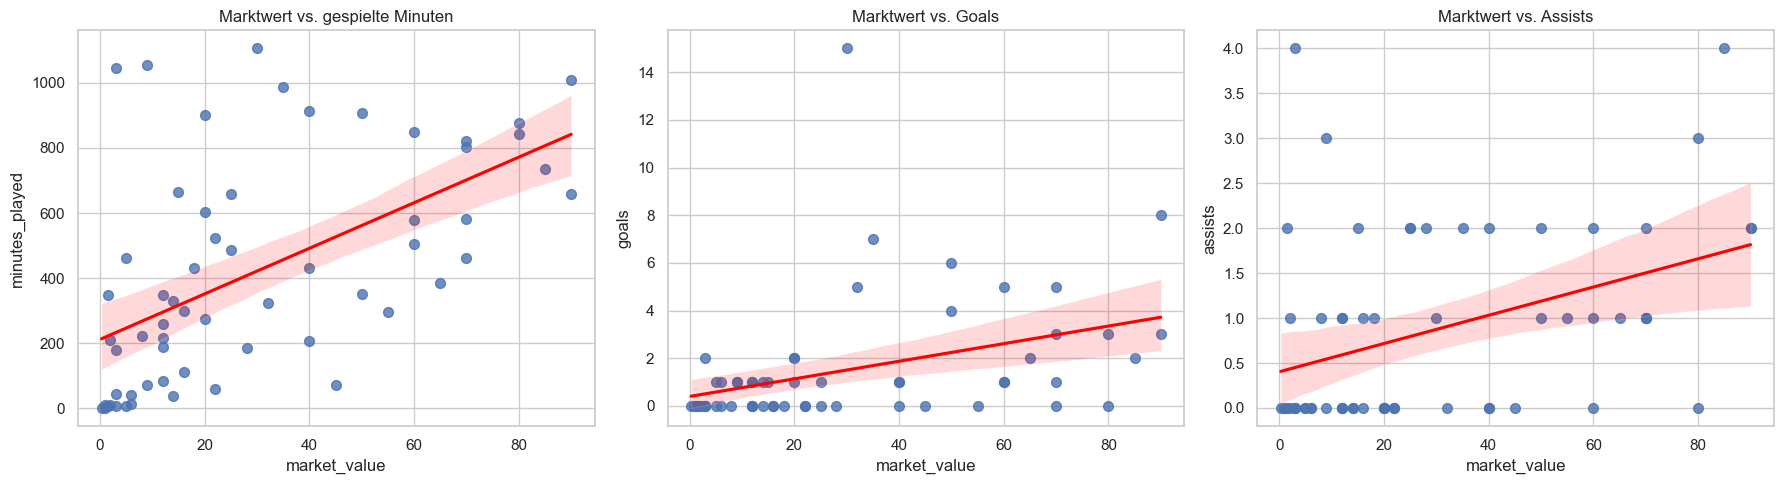

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     9.305
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           4.35e-05
Time:                        23:44:40   Log-Likelihood:                -270.48
No. Observations:                  60   AIC:                             549.0
Df Residuals:                      56   BIC:                             557.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.6671      4.730      2.

In [17]:
# 1. Analyse von goals, assists und minutes_playsed im zusammenhang zum Marktwert

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

# CSV-Daten laden
data = pd.read_csv('marktwerte_keystats.csv')

# Torhüter und Verteidiger ausschließen
df_angriff_mittelfeld = data[(data['position'] != 'Goalkeeper') & (data['position'] != 'Defender')]

# Deskriptive Statistik
print(df_angriff_mittelfeld[['market_value', 'minutes_played', 'goals', 'assists']].describe())
print()

# Korrelation berechnen
corr_mp = pearsonr(df_angriff_mittelfeld['market_value'], df_angriff_mittelfeld['minutes_played'])
corr_goals = pearsonr(df_angriff_mittelfeld['market_value'], df_angriff_mittelfeld['goals'])
corr_assists = pearsonr(df_angriff_mittelfeld['market_value'], df_angriff_mittelfeld['assists'])

print(f"Korrelation Marktwert vs. Minutes Played: {corr_mp[0]:.2f}, p-Wert: {corr_mp[1]:.4f}")
print(f"Korrelation Marktwert vs. Goals: {corr_goals[0]:.2f}, p-Wert: {corr_goals[1]:.4f}")
print(f"Korrelation Marktwert vs. Assists: {corr_assists[0]:.2f}, p-Wert: {corr_assists[1]:.4f}")

# Scatterplots mit Regressionslinien
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.regplot(x='market_value', y='minutes_played', data=df_angriff_mittelfeld, scatter_kws={"s": 50}, line_kws={"color": "red"})
plt.title('Marktwert vs. gespielte Minuten')

plt.subplot(1, 3, 2)
sns.regplot(x='market_value', y='goals', data=df_angriff_mittelfeld, scatter_kws={"s": 50}, line_kws={"color": "red"})
plt.title('Marktwert vs. Goals')

plt.subplot(1, 3, 3)
sns.regplot(x='market_value', y='assists', data=df_angriff_mittelfeld, scatter_kws={"s": 50}, line_kws={"color": "red"})
plt.title('Marktwert vs. Assists')

plt.tight_layout()
plt.show()

# Lineare Regression durchführen
X = df_angriff_mittelfeld[['minutes_played', 'goals', 'assists']]
y = df_angriff_mittelfeld['market_value']

# Hinzufügen einer Konstante für das Regressionsmodell
X = sm.add_constant(X)

# Regression anpassen
model = sm.OLS(y, X).fit()

# Regressionsergebnisse anzeigen
print(model.summary())

       market_value  balls_recoverd    tackles      t_won  clearance_attempted
count     33.000000       33.000000  33.000000  33.000000            33.000000
mean      28.251515       31.696970   5.757576   2.727273            15.757576
std       23.732232       23.179308   5.706522   3.319193            15.550382
min        0.800000        1.000000   0.000000   0.000000             0.000000
25%        8.000000        8.000000   1.000000   0.000000             5.000000
50%       20.000000       34.000000   4.000000   1.000000            13.000000
75%       45.000000       51.000000   8.000000   4.000000            19.000000
max       80.000000       76.000000  20.000000  12.000000            62.000000

Korrelation Marktwert vs. Balls Recovered: 0.66, p-Wert: 0.0000
Korrelation Marktwert vs. Tackles: 0.40, p-Wert: 0.0206
Korrelation Marktwert vs. T-Won: 0.31, p-Wert: 0.0802
Korrelation Marktwert vs. Clearance Attempted: 0.34, p-Wert: 0.0549



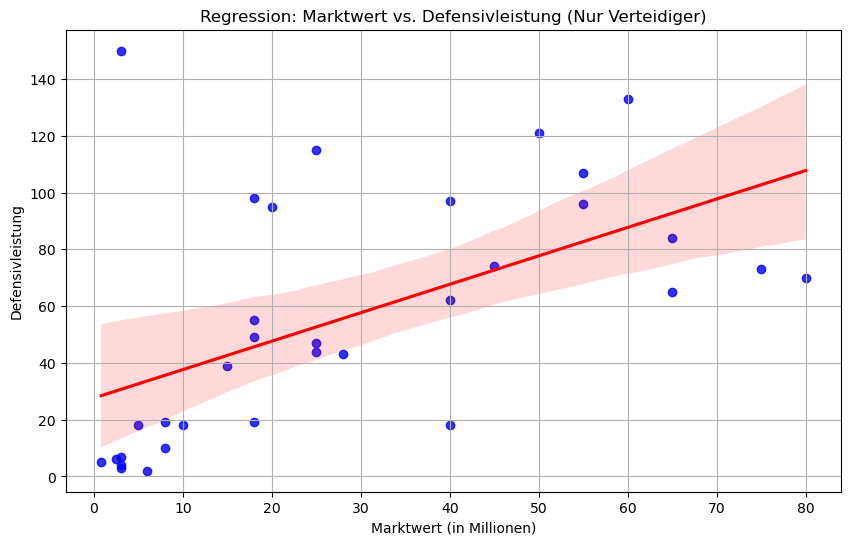

                              OLS Regression Results                             
Dep. Variable:     defensive_performance   R-squared:                       0.306
Model:                               OLS   Adj. R-squared:                  0.283
Method:                    Least Squares   F-statistic:                     13.64
Date:                   Fri, 31 Jan 2025   Prob (F-statistic):           0.000851
Time:                           00:01:23   Log-Likelihood:                -164.43
No. Observations:                     33   AIC:                             332.9
Df Residuals:                         31   BIC:                             335.9
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           27

In [2]:
# 2. Analyse defending im zusammenhang zum Markwert

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr

# CSV-Datei laden
df = pd.read_csv('marktwerte_defending.csv')

# Nur Verteidiger berücksichtigen
df_verteidiger = df[df['position'] == 'Defender'].copy()

print(df_verteidiger[['market_value', 'balls_recoverd', 'tackles', 't_won', 'clearance_attempted']].describe())
print()

# Korrelationen berechnen
corr_balls_recovered = pearsonr(df_verteidiger['market_value'], df_verteidiger['balls_recoverd'])
corr_tackles = pearsonr(df_verteidiger['market_value'], df_verteidiger['tackles'])
corr_t_won = pearsonr(df_verteidiger['market_value'], df_verteidiger['t_won'])
corr_clearance_attempted = pearsonr(df_verteidiger['market_value'], df_verteidiger['clearance_attempted'])

# Ausgabe der Korrelationen
print(f"Korrelation Marktwert vs. Balls Recovered: {corr_balls_recovered[0]:.2f}, p-Wert: {corr_balls_recovered[1]:.4f}")
print(f"Korrelation Marktwert vs. Tackles: {corr_tackles[0]:.2f}, p-Wert: {corr_tackles[1]:.4f}")
print(f"Korrelation Marktwert vs. T-Won: {corr_t_won[0]:.2f}, p-Wert: {corr_t_won[1]:.4f}")
print(f"Korrelation Marktwert vs. Clearance Attempted: {corr_clearance_attempted[0]:.2f}, p-Wert: {corr_clearance_attempted[1]:.4f}")
print()

# Defensivleistung berechnen (Summe aus relevanten Spalten)
df_verteidiger['defensive_performance'] = (
    df_verteidiger['balls_recoverd'] + df_verteidiger['tackles'] + df_verteidiger['t_won'] + df_verteidiger['clearance_attempted']
)

# Regressionslinie visualisieren
plt.figure(figsize=(10, 6))
sns.regplot(data=df_verteidiger, x='market_value', y='defensive_performance', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Regression: Marktwert vs. Defensivleistung (Nur Verteidiger)')
plt.xlabel('Marktwert (in Millionen)')
plt.ylabel('Defensivleistung')
plt.grid()
plt.show()

# Lineare Regression durchführen
X = df_verteidiger['market_value']
y = df_verteidiger['defensive_performance']

# Hinzufügen einer Konstante für das Regressionsmodell
X = sm.add_constant(X)

# Regression anpassen
model = sm.OLS(y, X).fit()

# Regressionsergebnisse anzeigen
print(model.summary())

count    75.000000
mean     83.852000
std       9.324153
min      44.500000
25%      81.250000
50%      85.700000
75%      89.900000
max      95.000000
Name: pass_accuracy, dtype: float64

Korrelation Marktwert vs. Passgenauigkeit: 0.17, p-Wert: 0.1414


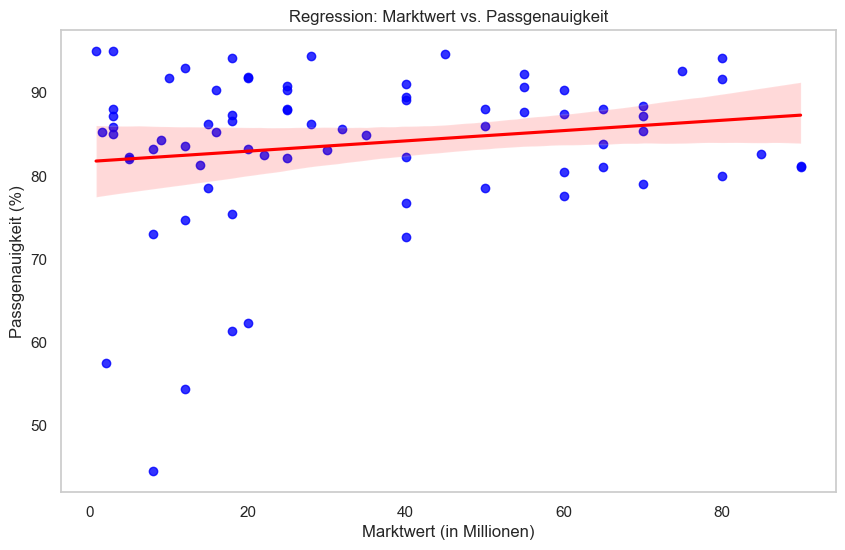

                            OLS Regression Results                            
Dep. Variable:          pass_accuracy   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.211
Date:                Thu, 30 Jan 2025   Prob (F-statistic):              0.141
Time:                        23:44:47   Log-Likelihood:                -272.24
No. Observations:                  75   AIC:                             548.5
Df Residuals:                      73   BIC:                             553.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           81.7392      1.778     45.985   

In [19]:
# 3. Analyse pass accurecy im zusammenhang zum Marktwert

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr

# CSV-Datei laden
df = pd.read_csv('marktwerte_distributon.csv')

# Torhüter ausschließen
df_angriff_mittelfeld = df[df['position'] != 'Goalkeeper']

print(df_angriff_mittelfeld['pass_accuracy'].describe())
print()

# Korrelationen berechnen
corr_pass_accuracy = pearsonr(df_angriff_mittelfeld['market_value'], df_angriff_mittelfeld['pass_accuracy'])

# Ausgabe der Korrelationen
print(f"Korrelation Marktwert vs. Passgenauigkeit: {corr_pass_accuracy[0]:.2f}, p-Wert: {corr_pass_accuracy[1]:.4f}")

# Regressionslinie visualisieren
plt.figure(figsize=(10, 6))
sns.regplot(data=df_angriff_mittelfeld, x='market_value', y='pass_accuracy', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Regression: Marktwert vs. Passgenauigkeit')
plt.xlabel('Marktwert (in Millionen)')
plt.ylabel('Passgenauigkeit (%)')
plt.grid()
plt.show()

# Lineare Regression durchführen
X = df_angriff_mittelfeld['market_value']
y = df_angriff_mittelfeld['pass_accuracy']

# Hinzufügen einer Konstante für das Regressionsmodell
X = sm.add_constant(X)

# Regression anpassen
model = sm.OLS(y, X).fit()

# Regressionsergebnisse anzeigen
print(model.summary())

